In [1]:
import os
import random
import argparse

import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from transformers import AutoModel

from m_dataset import CustomDataset
# from model import Expert, MoE


100%|██████████| 80/80 [01:54<00:00,  1.43s/it]


Total accuracy: 60.78%


Text(0.5, 1.0, 'MoE Confusion Matrix Without Regularization Term')

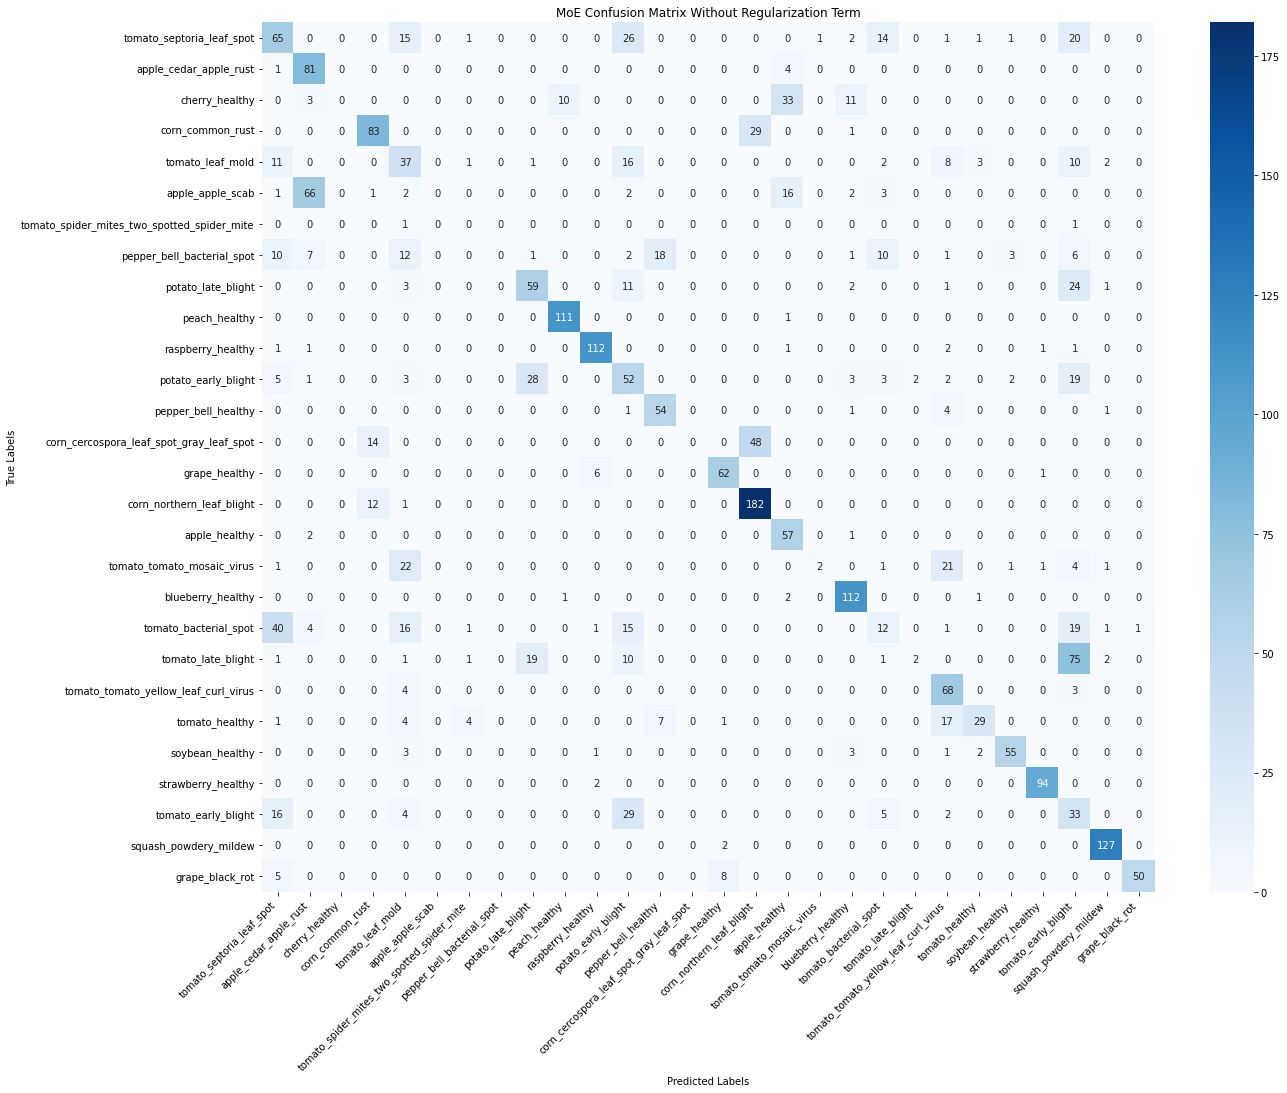

In [2]:


batch_size = 32
device = "cuda"
   
val_data = CustomDataset(
    data_root="../../../plantDoc",
    split_type = "valid",
    limit=False,
    model_name="google/vit-base-patch16-224-in21k"
)

val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=0)

# Define class name mapping
class_name_mapping = {'tomato_septoria_leaf_spot': 0, 'apple_cedar_apple_rust': 1, 'cherry_healthy': 2, 'corn_common_rust': 3, 'tomato_leaf_mold': 4, 'apple_apple_scab': 5, 'tomato_spider_mites_two_spotted_spider_mite': 6, 'pepper_bell_bacterial_spot': 7, 'potato_late_blight': 8, 'peach_healthy': 9, 'raspberry_healthy': 10, 'potato_early_blight': 11, 'pepper_bell_healthy': 12, 'corn_cercospora_leaf_spot_gray_leaf_spot': 13, 'grape_healthy': 14, 'corn_northern_leaf_blight': 15, 'apple_healthy': 16, 'tomato_tomato_mosaic_virus': 17, 'blueberry_healthy': 18, 'tomato_bacterial_spot': 19, 'tomato_late_blight': 20, 'tomato_tomato_yellow_leaf_curl_virus': 21, 'tomato_healthy': 22, 'soybean_healthy': 23, 'strawberry_healthy': 24, 'tomato_early_blight': 25, 'squash_powdery_mildew': 26, 'grape_black_rot': 27}

# Initialize confusion matrix and class names
num_classes = len(class_name_mapping)
conf_matrix = np.zeros((num_classes, num_classes), dtype=int)
class_names = sorted(class_name_mapping, key=lambda k: class_name_mapping[k])

epoch_name_int = 12
epoch_name = str(epoch_name_int)

val_model = torch.load("checkpoints/MOE_NOREG_PV200.pt")
for param in val_model.parameters():
    param.requires_grad = False

val_model.addNoise = False
val_model.eval()

# Accumulate predictions and true labels
for batch in tqdm(val_loader):
    images = batch["pixel_values"].to(device)
    labels = batch["labels"].to(device)
    img_names = batch["img_name"]
    val_model.addNoise = True
    
    with torch.no_grad():
        output, gate_out, expert_out = val_model(images)

    _, predicted = torch.max(output, 1)
    true_classes = torch.argmax(labels, dim=1)
    predicted = predicted.cpu().numpy()
    true_labels = labels.cpu().numpy()

    # Update confusion matrix
    for i in range(len(true_labels)):
        true_label_idx = np.argmax(true_labels[i])  # Use np.argmax to get the class index
        predicted_label_idx = predicted[i]
        conf_matrix[true_label_idx, predicted_label_idx] += 1
        

# Calculate accuracy
total_accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
print(f"Total accuracy: {total_accuracy:.2%}")

# Display confusion matrix with labels
plt.figure(figsize=(20, 16))
heatmap = sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

# Set color of class names (tick labels) to black
heatmap.set_xticklabels(class_names, rotation=45, ha='right', fontsize=10, color='black')
heatmap.set_yticklabels(class_names, rotation=0, ha='right', fontsize=10, color='black')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('MoE Confusion Matrix Without Regularization Term')



100%|██████████| 80/80 [01:52<00:00,  1.41s/it]


Total accuracy: 67.77%


Text(0.5, 1.0, 'MoE Confusion Matrix With Regularization Term')

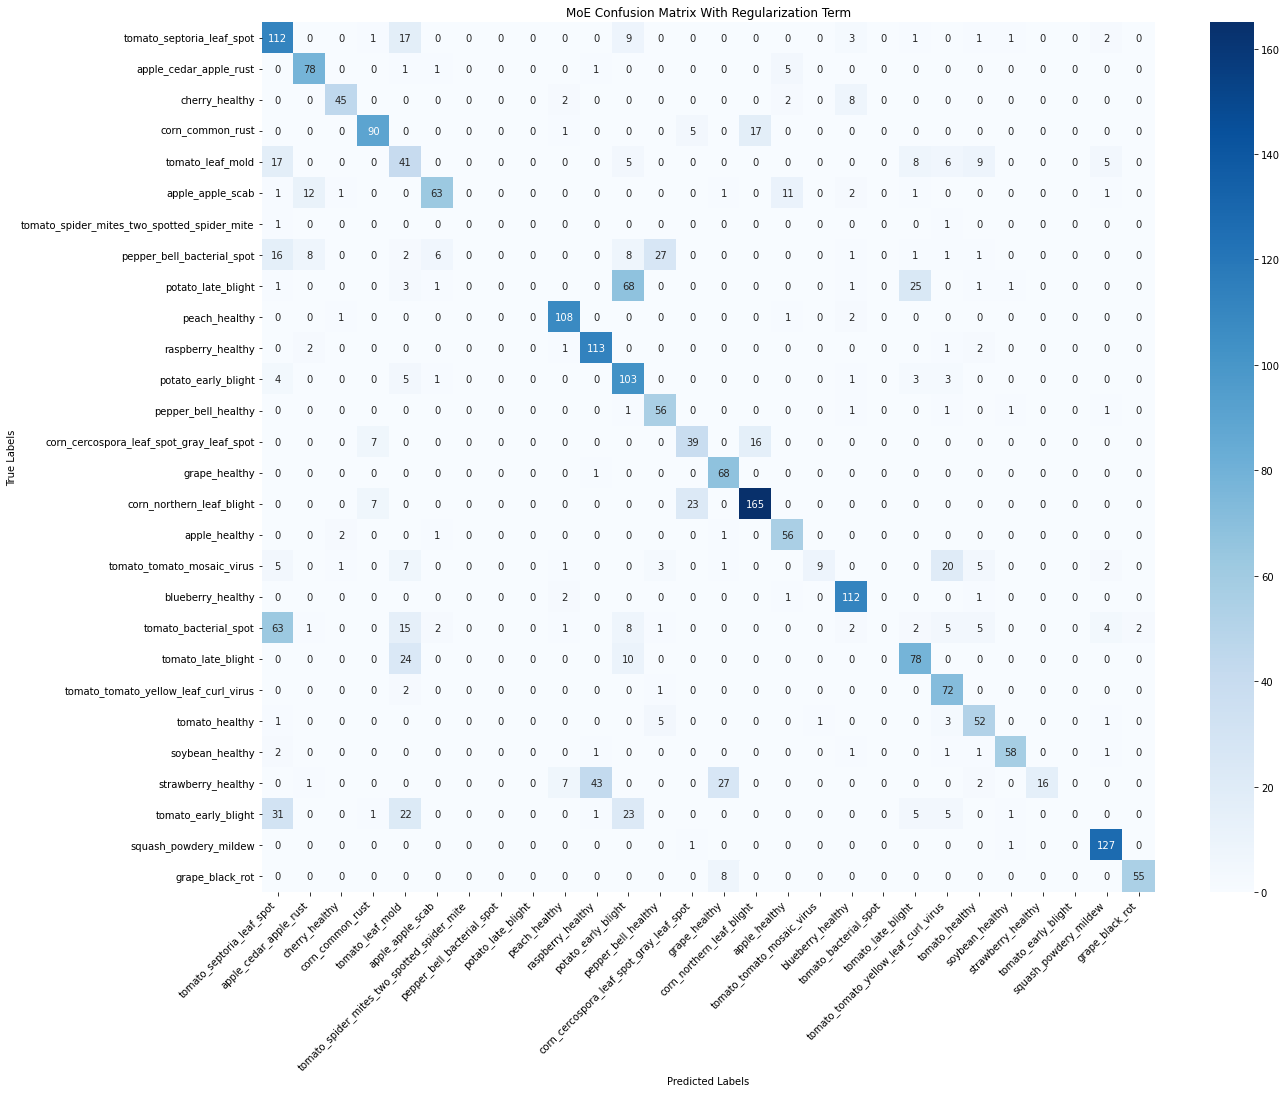

In [3]:
batch_size = 32
device = "cuda"
   
val_data = CustomDataset(
    data_root="../../../plantDoc",
    split_type = "valid",
    limit=False,
    model_name="google/vit-base-patch16-224-in21k"
)

val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=0)

# Define class name mapping
class_name_mapping = {'tomato_septoria_leaf_spot': 0, 'apple_cedar_apple_rust': 1, 'cherry_healthy': 2, 'corn_common_rust': 3, 'tomato_leaf_mold': 4, 'apple_apple_scab': 5, 'tomato_spider_mites_two_spotted_spider_mite': 6, 'pepper_bell_bacterial_spot': 7, 'potato_late_blight': 8, 'peach_healthy': 9, 'raspberry_healthy': 10, 'potato_early_blight': 11, 'pepper_bell_healthy': 12, 'corn_cercospora_leaf_spot_gray_leaf_spot': 13, 'grape_healthy': 14, 'corn_northern_leaf_blight': 15, 'apple_healthy': 16, 'tomato_tomato_mosaic_virus': 17, 'blueberry_healthy': 18, 'tomato_bacterial_spot': 19, 'tomato_late_blight': 20, 'tomato_tomato_yellow_leaf_curl_virus': 21, 'tomato_healthy': 22, 'soybean_healthy': 23, 'strawberry_healthy': 24, 'tomato_early_blight': 25, 'squash_powdery_mildew': 26, 'grape_black_rot': 27}

# Initialize confusion matrix and class names
num_classes = len(class_name_mapping)
conf_matrix = np.zeros((num_classes, num_classes), dtype=int)
class_names = sorted(class_name_mapping, key=lambda k: class_name_mapping[k])

epoch_name_int = 12
epoch_name = str(epoch_name_int)

val_model = torch.load("checkpoints/MOE_REG_PV200_FD2_3.pt")
for param in val_model.parameters():
    param.requires_grad = False

val_model.addNoise = False
val_model.eval()

# Accumulate predictions and true labels
for batch in tqdm(val_loader):
    images = batch["pixel_values"].to(device)
    labels = batch["labels"].to(device)
    img_names = batch["img_name"]
    val_model.addNoise = True
    
    with torch.no_grad():
        output, gate_out, expert_out = val_model(images)

    _, predicted = torch.max(output, 1)
    true_classes = torch.argmax(labels, dim=1)
    predicted = predicted.cpu().numpy()
    true_labels = labels.cpu().numpy()

    # Update confusion matrix
    for i in range(len(true_labels)):
        true_label_idx = np.argmax(true_labels[i])  # Use np.argmax to get the class index
        predicted_label_idx = predicted[i]
        conf_matrix[true_label_idx, predicted_label_idx] += 1
        

# Calculate accuracy
total_accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
print(f"Total accuracy: {total_accuracy:.2%}")

# Display confusion matrix with labels
plt.figure(figsize=(20, 16))
heatmap = sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

# Set color of class names (tick labels) to black
heatmap.set_xticklabels(class_names, rotation=45, ha='right', fontsize=10, color='black')
heatmap.set_yticklabels(class_names, rotation=0, ha='right', fontsize=10, color='black')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('MoE Confusion Matrix With Regularization Term')



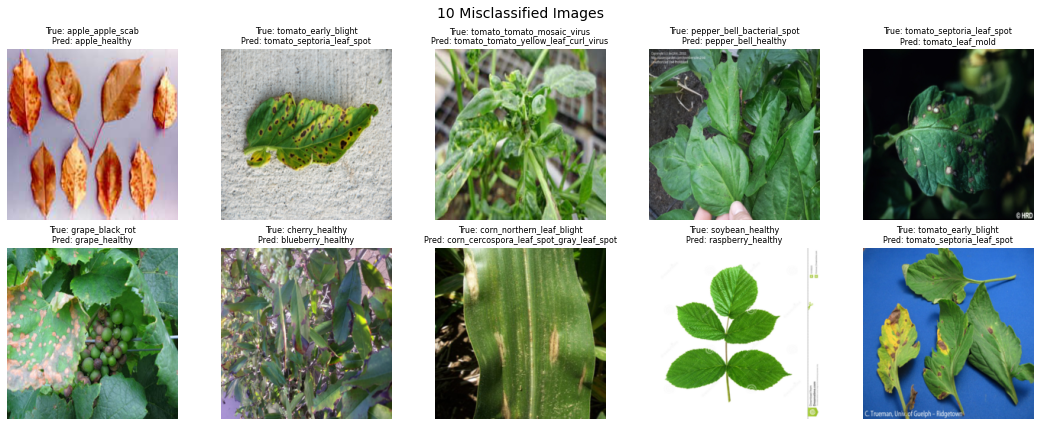

In [4]:
val_model.eval()

# Store misclassified examples
misclassified_images = []
misclassified_true_labels = []
misclassified_predicted_labels = []

# Re-iterate over the validation data to collect misclassified examples
for batch in val_loader:
    images = batch["pixel_values"].to(device)
    labels = batch["labels"].to(device)
    img_names = batch["img_name"]
    val_model.addNoise = True

    with torch.no_grad():
        output, gate_out, expert_out = val_model(images)

    _, predicted = torch.max(output, 1)
    true_classes = torch.argmax(labels, dim=1)

    for i in range(images.size(0)):
        if predicted[i] != true_classes[i]:
            misclassified_images.append(images[i].cpu())
            misclassified_true_labels.append(true_classes[i].item())
            misclassified_predicted_labels.append(predicted[i].item())

# Select any 10 misclassified samples randomly
selected_indices = random.sample(range(len(misclassified_images)), 10)

# Plot the 5x2 matrix
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
axs = axs.flatten()

for i, idx in enumerate(selected_indices):
    img = misclassified_images[idx]
    true_label = class_names[misclassified_true_labels[idx]]
    predicted_label = class_names[misclassified_predicted_labels[idx]]

    # Move channel dimension to the end and unnormalize if needed
    img = img.permute(1, 2, 0)
    img = img.numpy()
    img = (img - img.min()) / (img.max() - img.min())  # normalize for display

    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(f'True: {true_label}\nPred: {predicted_label}', fontsize=8)

plt.tight_layout()
plt.suptitle("10 Misclassified Images", fontsize=14)
plt.subplots_adjust(top=0.88)
plt.show()


In [5]:
# Store cname along with predictions
def evaluate_model(model_path):
    model = torch.load(model_path)
    model.to(device)
    model.eval()
    model.addNoise = False

    all_preds, all_trues, all_img_names, all_class_dirs = [], [], [], []

    with torch.no_grad():
        for batch in tqdm(val_loader):
            images = batch["pixel_values"].to(device)
            labels = batch["labels"]
            img_names = batch["img_name"]
            cnames = batch["cname"]  # this gives class directory name

            model.addNoise = True
            outputs, _, _ = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            trues = torch.argmax(labels, dim=1).numpy()

            all_preds.extend(preds)
            all_trues.extend(trues)
            all_img_names.extend(img_names)
            all_class_dirs.extend(cnames)

    return np.array(all_preds), np.array(all_trues), all_img_names, all_class_dirs

# Evaluate both models
preds_before, trues, img_names, class_dirs = evaluate_model("checkpoints/MOE_NOREG_PV200.pt")
preds_after, _, _, _ = evaluate_model("checkpoints/MOE_REG_PV200_FD2_3.pt")

# Identify indices where misclassified before and corrected after
recovered_indices = [i for i in range(len(trues)) if preds_before[i] != trues[i] and preds_after[i] == trues[i]]

# Data root
data_root = "../../../plantDoc"



100%|██████████| 80/80 [01:49<00:00,  1.37s/it]


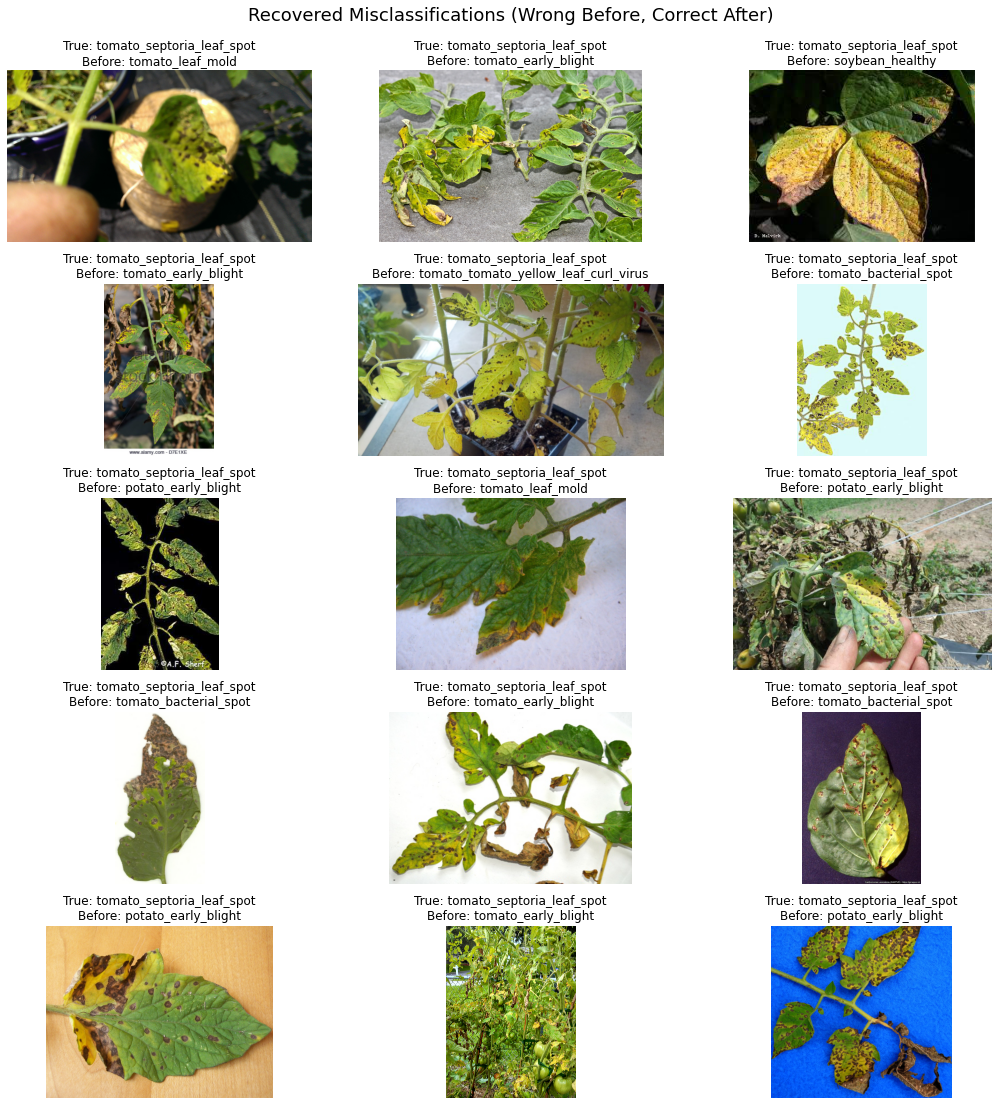

In [6]:
plt.figure(figsize=(15, 15))
for idx, i in enumerate(recovered_indices[:15]):
    img_path = os.path.join(data_root, class_dirs[i], img_names[i])
    try:
        img = Image.open(img_path).convert("RGB")
    except Exception as e:
        print(f"Could not open {img_path}: {e}")
        continue

    plt.subplot(5, 3, idx + 1)
    plt.imshow(img)
    plt.title(f"True: {class_names[trues[i]]}\nBefore: {class_names[preds_before[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Recovered Misclassifications (Wrong Before, Correct After)", fontsize=18, y=1.02)
plt.show()